In [2]:
#import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
keras.__version__

'3.8.0'

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv('/home/krzysztof/.keras/datasets/jena_climate_2009_2016_extracted/jena_climate_2009_2016.csv')

In [5]:
df.keys()
selected_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'Tdew (degC)', 'VPmax (mbar)']
target_columns = ['p (mbar)', 'T (degC)', 'rh (%)']

# Uzyskanie indeksów kolumn
input_indices = [df.columns.get_loc(col) for col in selected_columns]
target_indices = [df.columns.get_loc(col) for col in target_columns]
# Wyświetlenie indeksów
print("Indeksy dla selected_columns:", input_indices)
print("Indeksy dla target_columns:", target_indices)

Indeksy dla selected_columns: [1, 2, 5, 4, 6]
Indeksy dla target_columns: [1, 2, 5]


Spójrzmy na dane.

In [6]:
df.head()
df.shape

(420551, 15)

In [7]:
def generator(data, lookback, delay, input_indices, target_indices, min_index, max_index,
              batch_size=128, samples_step=1, targets_step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    
    while True:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)

        # Przygotowanie próbek i celów
        samples = np.zeros((len(rows), lookback // samples_step, len(input_indices)))
        targets = np.zeros((len(rows), delay // targets_step, len(target_columns)))
        
        for j, row in enumerate(rows):
            # Indeksy dla próbek i celów
            s_indices = list(range(rows[j] - lookback, rows[j], samples_step))
            t_indices = list(range(rows[j], rows[j] + delay, targets_step))
            
            # Upewnij się, że indeksy nie wykraczają poza zakres
            if max(s_indices) >= len(data) or max(t_indices) >= len(data):
                continue

            # Pobranie próbek i celów
            samples[j] = data[s_indices][:, input_indices]
            targets[j] = data[t_indices][:, target_indices]
        
        yield samples, targets


In [8]:
TRAIN_SPLIT = 330000
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
data = df.drop(['Date Time'], axis=1)
dataset = data.values
dataset.shape

(420551, 14)

In [10]:
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

print(data_mean)
print("#############")
print(data_std)

[ 988.80187064    8.92632655  283.00079882    4.55339067   76.48203409
   13.13652715    9.31004185    3.82639936    5.88299973    9.4177223
 1217.93582064    2.151373      3.55671667  174.1361133 ]
#############
[ 8.37526559  8.47974514  8.55663505  6.8792257  16.35201742  7.51162222
  4.17803453  4.66189232  2.65203329  4.2294396  40.31981161  1.54040076
  2.33407965 87.06572617]


In [11]:
#3 dni prubek - 1 na 20min
lookback = 432
s_step = 3
#input_indices 

#24 godziny do przodu - 1 na 60min
t_step = 6
delay = 144
#target_indices

batch_size = 128


train_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=0,
                      max_index=TRAIN_SPLIT,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)
val_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=TRAIN_SPLIT + 1,
                      max_index=TRAIN_SPLIT + 45275,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)
test_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=TRAIN_SPLIT + 45276,
                      max_index=None,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)

# Liczba kroków pobierania danych z obiektu val_gen
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (45276 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen,
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(dataset) - TRAIN_SPLIT - 45276 -lookback) // batch_size

train_steps = (TRAIN_SPLIT - lookback) // batch_size

print(train_steps, val_steps, test_steps)

2574 350 350


In [16]:
samples, targets = next(train_gen)
print(samples.shape, targets.shape)

(128, 144, 5) (128, 24, 3)


In [17]:
model_rnn = models.Sequential()
model_rnn.add(layers.LSTM(32, return_sequences=True, input_shape=(None, samples.shape[-1])))
model_rnn.add(layers.LSTM(16))
model_rnn.add(layers.Dense((delay // t_step) * 3)) 
model_rnn.add(layers.Reshape((delay // t_step, 3))) 

model_rnn.compile(optimizer='adam', loss='mae')
model_rnn.summary()

I0000 00:00:1737572821.686169  214442 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1124 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
/home/krzysztof/my-jupyter/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 32)       │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,224 (36.03 KB)

 Trainable params: 9,224 (36.03 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model_rnn.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20


I0000 00:00:1737558194.128317  149683 cuda_dnn.cc:529] Loaded cuDNN version 90300


2574/2574 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.4760 - val_loss: 0.3995
Epoch 2/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.2870 - val_loss: 0.3693
Epoch 3/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.2639 - val_loss: 0.3607
Epoch 4/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.2555 - val_loss: 0.3486
Epoch 5/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.2498 - val_loss: 0.3420
Epoch 6/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.2458 - val_loss: 0.3344
Epoch 7/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.2428 - val_loss: 0.3275
Epoch 8/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.2404 - val_loss: 0.3238
Epoch 9/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.2386 - val_loss: 0.3198
Epoch 10/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.2371 - val_loss: 0.3162
Epoch 11/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.2355 - val_loss: 0.3153
Epoch 12/20
2574/25

Wykorzystanie Transformerow

In [12]:
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        self.pos_encoding = self.compute_positional_encoding()

    def compute_positional_encoding(self):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        dimensions = np.arange(self.d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(self.d_model))
        angle_rads = positions * angle_rates

        # Sinus i cosinus
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

# Transformer block
def transformer_block(inputs, num_heads, ff_dim):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)

    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Add()([attention_output, ffn_output])  # Residual connection
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output

In [ ]:

d_model = 32
num_transformer_blocks = 2
num_heads = 4
ff_dim = 64

inputs = layers.Input(shape=(None, samples.shape[-1])) 
x = layers.Dense(d_model)(inputs)  
x = PositionalEncodingLayer(samples.shape[1], d_model)(x)  

# Dodanie bloków Transformera
for _ in range(num_transformer_blocks):
    x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim)

# Global average pooling
x = layers.GlobalAveragePooling1D()(x)

# Wyjściowa warstwa Dense
outputs = layers.Dense((delay // t_step) * 3)(x)
outputs = layers.Reshape((delay // t_step, 3))(outputs)

# Kompilacja modelu
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae')
# Wyświetlenie architektury modelu
model.summary()

In [ ]:
history1 = model.fit(
    train_gen,  # Generator treningowy
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen, 
    validation_steps=val_steps
)

In [ ]:
import matplotlib.pyplot as plt

samples, targets = next(test_gen)

# Uzyskanie przewidywań z obu modeli
pred_rnn = model_rnn.predict(samples)
pred_transformer = model.predict(samples)

for i in range(86,90):
    target_pressure = targets[i][:,0]  # Target p (mbar)
    target_temp = targets[i][:,1]      # Target T (degC)
    target_humidity = targets[i][:,2]  # Target rh (%)

    pred_rnn_pressure = pred_rnn[i][:,0]
    pred_rnn_temp = pred_rnn[i][:,1]
    pred_rnn_humidity = pred_rnn[i][:,2]

    pred_transformer_pressure = pred_transformer[i][:,0]
    pred_transformer_temp = pred_transformer[i][:,1]
    pred_transformer_humidity = pred_transformer[i][:,2]

    # Tworzenie wykresu
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Wykres dla ciśnienia
    axes[0].set_title('Ciśnienie (p)')
    axes[0].plot(target_pressure, label='Target', color='blue')
    axes[0].plot(pred_rnn_pressure, label='RNN', color='red')
    axes[0].plot(pred_transformer_pressure, label='Transformer', color='green')

    # Wykres dla temperatury
    axes[1].set_title('Temperatura (T)')
    axes[1].plot(target_temp, label='Target', color='blue')
    axes[1].plot(pred_rnn_temp, label='RNN', color='red')
    axes[1].plot(pred_transformer_temp, label='Transformer', color='green')

    # Wykres dla wilgotności
    axes[2].set_title('Wilgotność (rh)')
    axes[2].plot(target_humidity, label='Target', color='blue')
    axes[2].plot(pred_rnn_humidity, label='RNN', color='red')
    axes[2].plot(pred_transformer_humidity, label='Transformer', color='green')

    # Ustawienie etykiet osi
    for i in range(3):
        axes[i].set_xlabel('Czas')
        axes[i].set_ylabel('Wartości')

    # Dodanie legendy do wykresów
    for i in range(3):
        axes[i].legend()

    # Dostosowanie układu
    plt.tight_layout()
    plt.show()


In [ ]:
plt.subplot(1, 2, 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('rnn_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.title('transformer_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')


plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [47]:
model_rnn.save_weights('saved_models/model_rnn.weights.h5')
model.save_weights('saved_models/model_transformer.weights.h5')

In [18]:
model_rnn.load_weights('/home/krzysztof/Documents/PrognozaPogody/saved_models/model_rnn.weights.h5')

/home/krzysztof/my-jupyter/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


obydwa modele sa przetrenowane, jednak tw wypadku transformera funkcja walidacyjna straty dalej znaczaco spada  

In [20]:
import keras_tuner as kt


def build_transformer_block(inputs, transformer_hp, i):
    # Parametry bloku
    atention_num_heads = transformer_hp.Int(f'atention_num_heads_{i}', min_value=8, max_value=16, step=4)
    atention_dropout_rate = transformer_hp.Float(f'atention_dropout_rate_{i}', min_value=0.0, max_value=0.4, step=0.1)
    key_dim = inputs.shape[-1]

    ffn_type = transformer_hp.Choice(f'ffn_type_{i}', ['Dense', 'Conv1D'])
    ffn_dim_power = transformer_hp.Int(f'ffn_dim_power_{i}', min_value=4, max_value=7, step=1)
    conv_kernel_size = transformer_hp.Int(f'conv_kernel_size_{i}', min_value=3, max_value=5, step=1)
    ffn_activation = transformer_hp.Choice(f'ffn_activation_{i}', ['relu', 'leaky_relu', 'swish'])

    ffn_dropout_rate = transformer_hp.Float(f'ffn_dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)
    
    # Attention
    attention_output = layers.MultiHeadAttention(num_heads=atention_num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = layers.Dropout(atention_dropout_rate)(attention_output)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)

    # FFN - wybór typu warstwy
    if ffn_type == "Dense":
        ffn_output = layers.Dense(2 ** (ffn_dim_power + 2), activation=ffn_activation)(attention_output)
    elif ffn_type == "Conv1D":
        ffn_output = layers.Conv1D(filters=2 ** ffn_dim_power, kernel_size=conv_kernel_size, activation=ffn_activation, padding='same')(attention_output)

    ffn_output = layers.Dropout(ffn_dropout_rate)(ffn_output)
    ffn_output = layers.Dense(key_dim)(ffn_output)  # Dopasowanie wymiaru
    ffn_output = layers.Add()([attention_output, ffn_output])  # Residual connection
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output


def build_model_for_transformer_tuning(transformer_hp):
    transformer_dim_power = transformer_hp.Int('transformer_dim_power', min_value=3, max_value=6, step=1)
    transformer_dim = 2 ** transformer_dim_power  # Wymiar transformera
    num_transformer_blocks = transformer_hp.Int('num_transformer_blocks', min_value=1, max_value=3, step=1)

    inputs = layers.Input(shape=(None, samples.shape[-1]))
    x = layers.Dense(transformer_dim)(inputs) 
    x = PositionalEncodingLayer(sequence_length=samples.shape[1], d_model=transformer_dim)(x)  
    
    for i in range(num_transformer_blocks):
        x = build_transformer_block(x, transformer_hp, i)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense((delay // t_step) * 3)(x)  
    outputs = layers.Reshape((delay // t_step, 3))(outputs) # Wyjście dla regresji


    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae')

    return model

In [17]:
tuner = kt.BayesianOptimization(
        build_model_for_transformer_tuning,
        objective='val_loss',
        max_trials=40,  # Maksymalna liczba prób
        executions_per_trial=1, 
        directory='my_dir',
        project_name='transformer_bayes'
    )

tuner.search(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps
)

Trial 40 Complete [00h 10m 32s]
val_loss: 0.33145883679389954

Best val_loss So Far: 0.3157845735549927
Total elapsed time: 20h 29m 20s


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=5)

# Wypisanie hiperparametrów
for i, hp in enumerate(best_hps, start=1):
    print(f"Zestaw {i}:")
    for param, value in hp.values.items():
        print(f"  {param}: {value}")
    print()

Zestaw 1:
  transformer_dim_power: 5
  num_transformer_blocks: 1
  atention_num_heads_0: 12
  atention_dropout_rate_0: 0.4
  ffn_type_0: Dense
  ffn_dim_power_0: 6
  conv_kernel_size_0: 4
  ffn_activation_0: leaky_relu
  ffn_dropout_rate_0: 0.30000000000000004
  atention_num_heads_1: 12
  atention_dropout_rate_1: 0.1
  ffn_type_1: Conv1D
  ffn_dim_power_1: 7
  conv_kernel_size_1: 3
  ffn_activation_1: swish
  ffn_dropout_rate_1: 0.0
  atention_num_heads_2: 8
  atention_dropout_rate_2: 0.30000000000000004
  ffn_type_2: Dense
  ffn_dim_power_2: 5
  conv_kernel_size_2: 4
  ffn_activation_2: relu
  ffn_dropout_rate_2: 0.30000000000000004

Zestaw 2:
  transformer_dim_power: 3
  num_transformer_blocks: 2
  atention_num_heads_0: 16
  atention_dropout_rate_0: 0.1
  ffn_type_0: Conv1D
  ffn_dim_power_0: 7
  conv_kernel_size_0: 4
  ffn_activation_0: leaky_relu
  ffn_dropout_rate_0: 0.4
  atention_num_heads_1: 12
  atention_dropout_rate_1: 0.30000000000000004
  ffn_type_1: Conv1D
  ffn_dim_power_

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


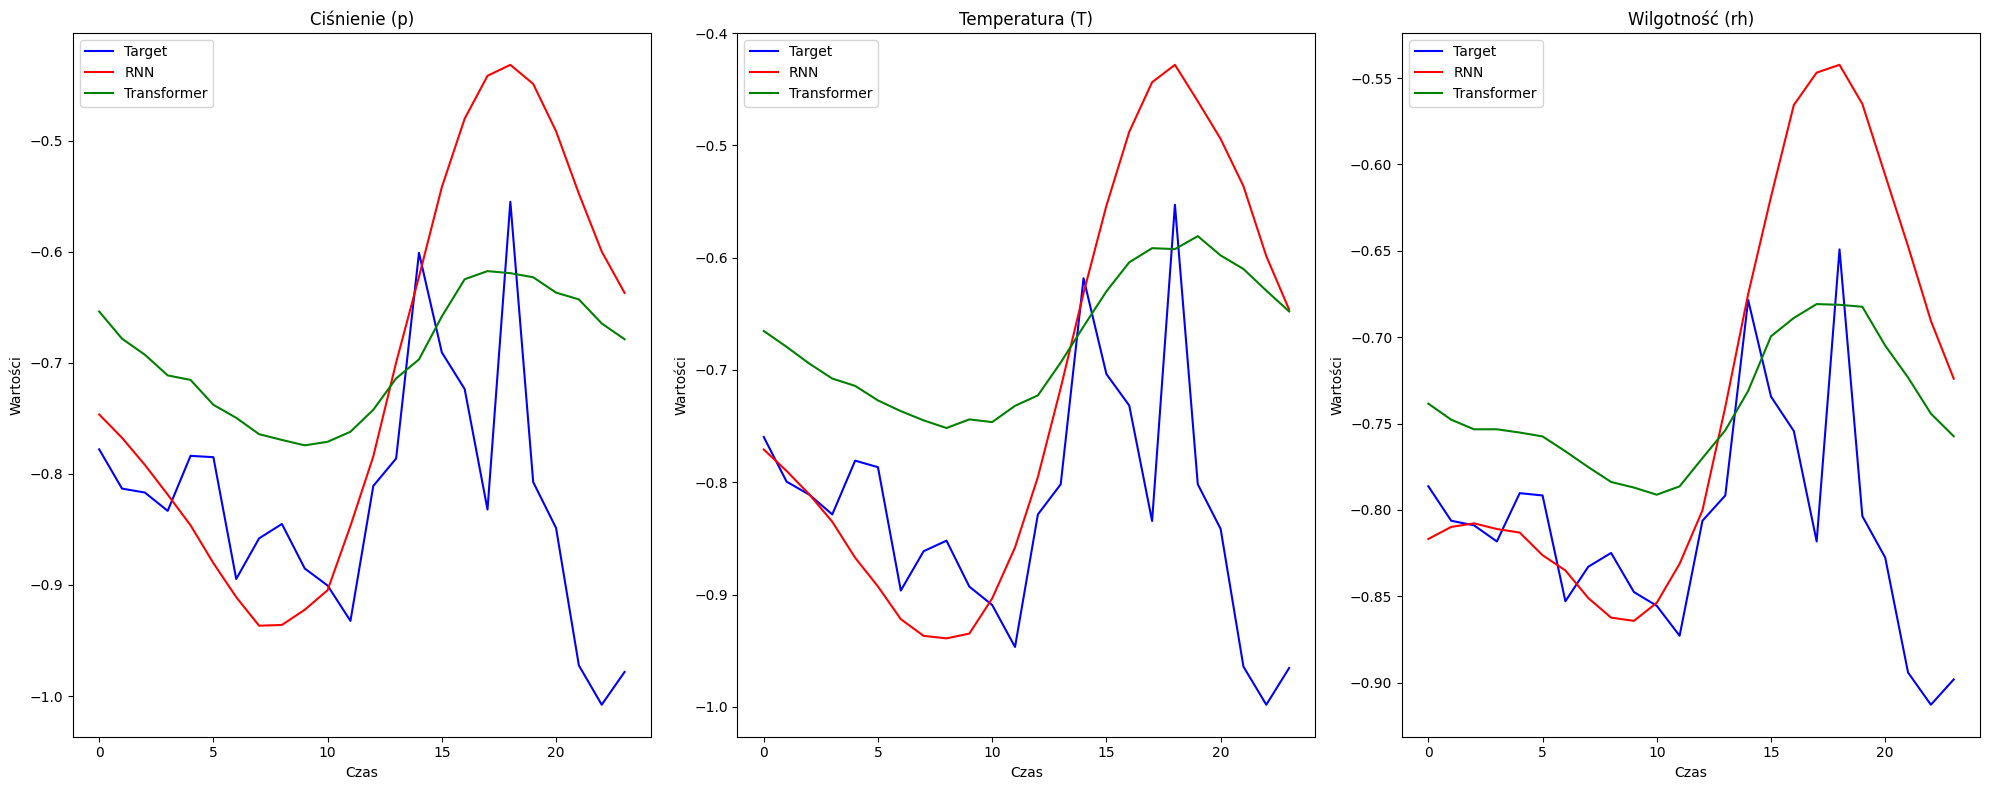

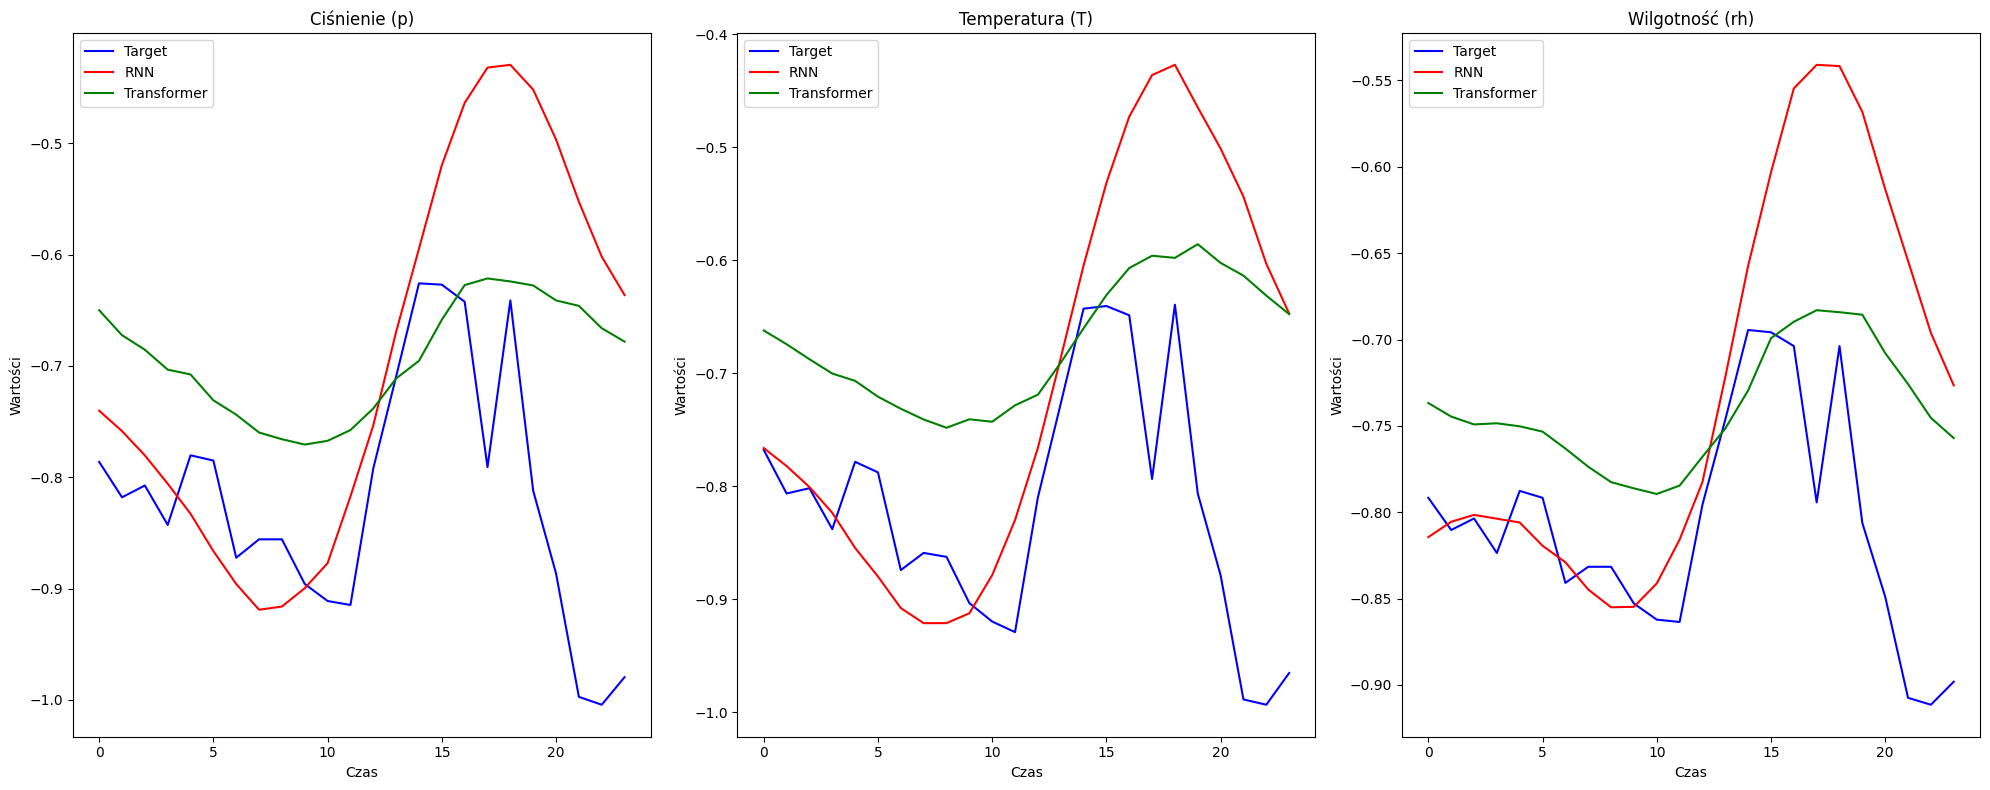

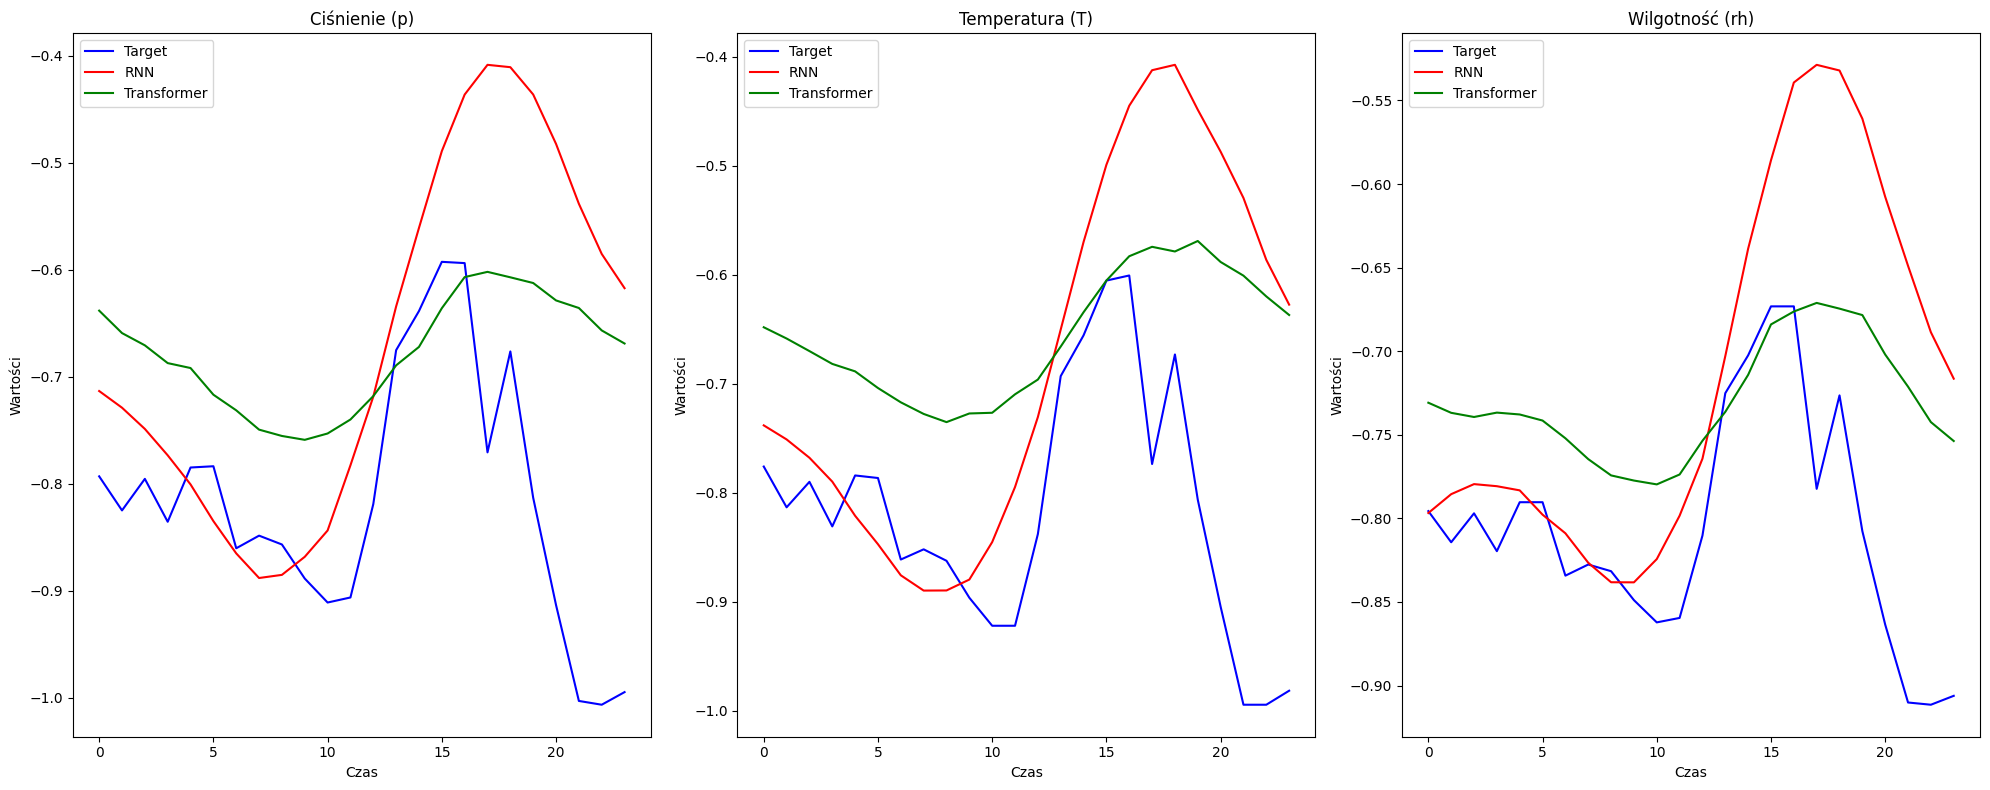

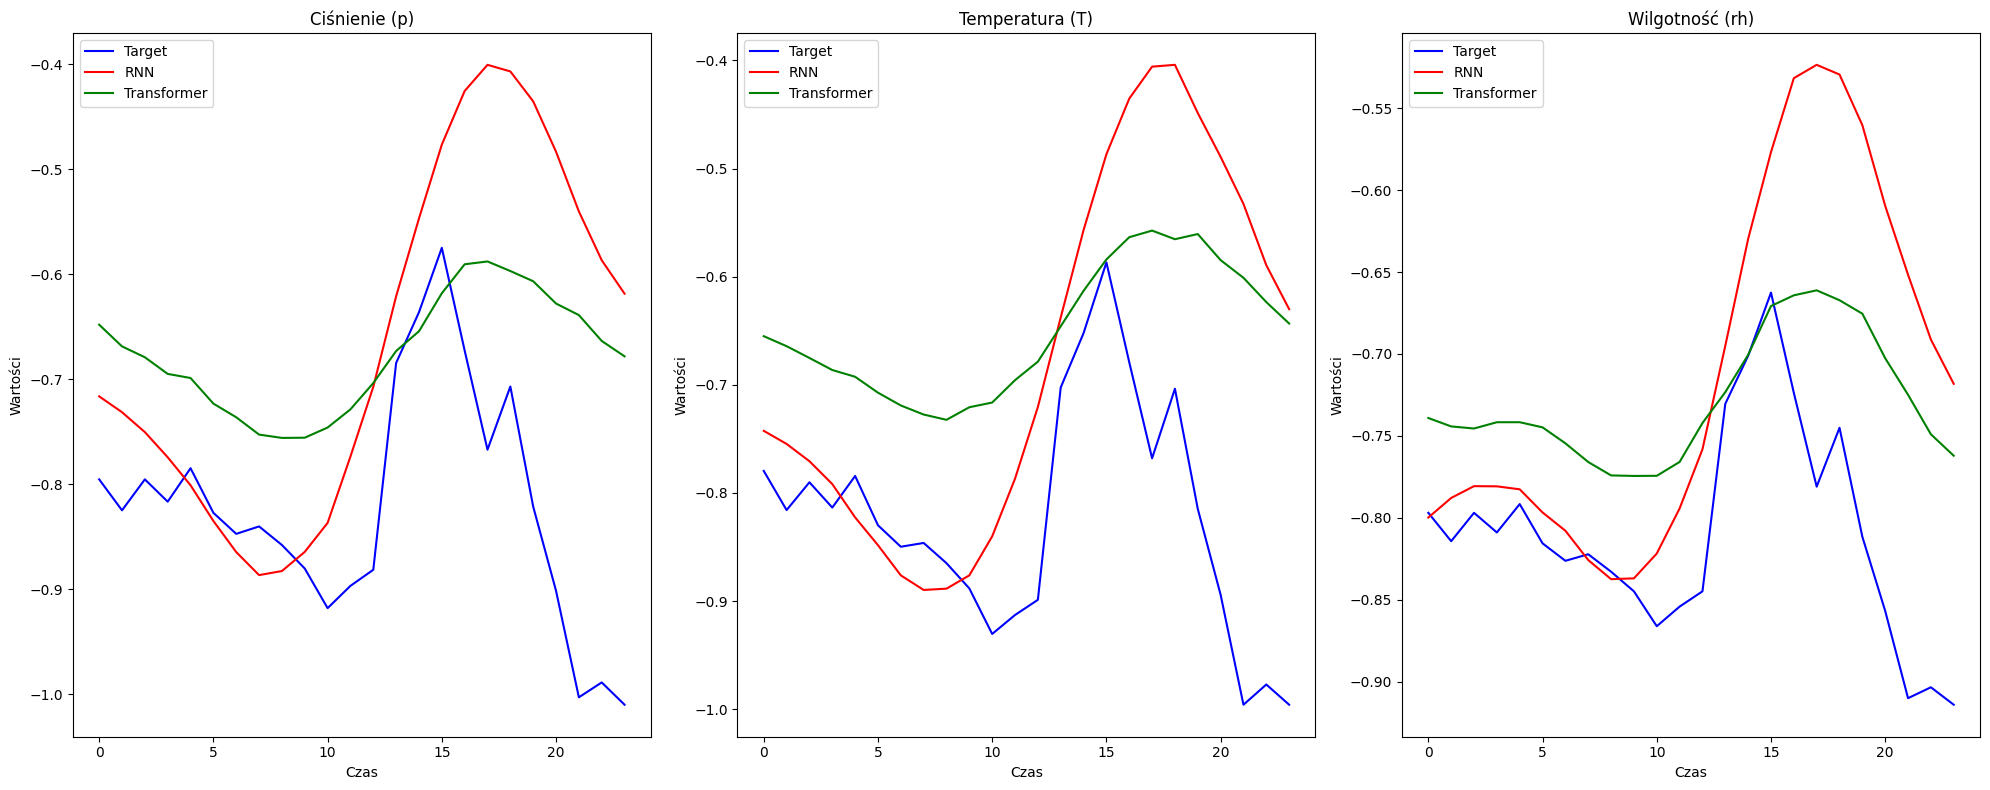

In [23]:

samples, targets = next(test_gen)

# Uzyskanie przewidywań z obu modeli
pred_rnn = model_rnn.predict(samples)

model = tuner.get_best_models(num_models=3)[0]
pred_transformer = model.predict(samples)

for i in range(86,90):
    target_pressure = targets[i][:,0]  # Target p (mbar)
    target_temp = targets[i][:,1]      # Target T (degC)
    target_humidity = targets[i][:,2]  # Target rh (%)

    pred_rnn_pressure = pred_rnn[i][:,0]
    pred_rnn_temp = pred_rnn[i][:,1]
    pred_rnn_humidity = pred_rnn[i][:,2]

    pred_transformer_pressure = pred_transformer[i][:,0]
    pred_transformer_temp = pred_transformer[i][:,1]
    pred_transformer_humidity = pred_transformer[i][:,2]

    # Tworzenie wykresu
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Wykres dla ciśnienia
    axes[0].set_title('Ciśnienie (p)')
    axes[0].plot(target_pressure, label='Target', color='blue')
    axes[0].plot(pred_rnn_pressure, label='RNN', color='red')
    axes[0].plot(pred_transformer_pressure, label='Transformer', color='green')

    # Wykres dla temperatury
    axes[1].set_title('Temperatura (T)')
    axes[1].plot(target_temp, label='Target', color='blue')
    axes[1].plot(pred_rnn_temp, label='RNN', color='red')
    axes[1].plot(pred_transformer_temp, label='Transformer', color='green')

    # Wykres dla wilgotności
    axes[2].set_title('Wilgotność (rh)')
    axes[2].plot(target_humidity, label='Target', color='blue')
    axes[2].plot(pred_rnn_humidity, label='RNN', color='red')
    axes[2].plot(pred_transformer_humidity, label='Transformer', color='green')

    # Ustawienie etykiet osi
    for i in range(3):
        axes[i].set_xlabel('Czas')
        axes[i].set_ylabel('Wartości')

    # Dodanie legendy do wykresów
    for i in range(3):
        axes[i].legend()

    # Dostosowanie układu
    plt.tight_layout()
    plt.show()


Tunowany transformer jest w stanie lepiej przewidziec trendy nix model rnn, podczas kolejnego fitowania postaram sie wprowadzic warzona funkcje straty, a takrze rozbudowac czesc ffn

In [25]:
def weighted_loss(y_true, y_pred):
    error = y_true - y_pred

    time_steps = tf.range(24, dtype=tf.float32)  
    weights = tf.exp(-time_steps / tf.constant(30.0))  

    weights = tf.expand_dims(weights, axis=-1)  
    weights = tf.expand_dims(weights, axis=0)  

    weighted_error = error * weights

    loss = tf.reduce_mean(tf.square(weighted_error))
    return loss


In [22]:
from tensorflow.keras.optimizers import Adam
def build_model_for_tuning(hp):
    transformer_dim_power = hp.Int('transformer_dim_power', min_value=5, max_value=6, step=1)
    transformer_dim = 2 ** transformer_dim_power
    attention_num_heads = hp.Int('attention_num_heads', min_value=10, max_value=16, step=2)
    ffn_dim_power = hp.Int('ffn_dim_power', min_value=7, max_value=9, step=1)

    inputs = layers.Input(shape=(None, samples.shape[-1]))
    x = layers.Dense(transformer_dim)(inputs) 
    x = PositionalEncodingLayer(sequence_length=samples.shape[1], d_model=transformer_dim)(x)

    # Transformer:
    key_dim = transformer_dim 

    # Attention Layer
    attention_output = layers.MultiHeadAttention(num_heads=attention_num_heads, key_dim=key_dim)(x, x)
    attention_output = layers.Add()([x, attention_output])  # Residual connection
    attention_output = layers.Dropout(0.4)(attention_output)  
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output) 

    # Feed Forward Network
    ffn_output = layers.Dense(2 ** ffn_dim_power, activation="relu")(attention_output)  
    ffn_output = layers.Dense(transformer_dim)(ffn_output)  
    ffn_output = layers.Dropout(0.3)(ffn_output)  

    # Final Feed Forward + Residual Connection
    ffn_output = layers.Add()([attention_output, ffn_output]) 
    x = layers.LayerNormalization(epsilon=1e-6)(ffn_output)  # Layer Normalization

    #############

    hidden_layers_num = hp.Int('hidden_layers_num', min_value=0, max_value=3, step=1)
    hidden_layers_neurons_pow = hp.Int('hidden_layers_neurons_pow', min_value=6, max_value=9, step=1)
    hidden_layers_activation = hp.Choice('hidden_layers_activation', ['relu', 'swish']) 
    hidden_layers_dropout = hp.Float('hidden_layers_dropout', min_value=0.0, max_value=0.5, step=0.1)

    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(hidden_layers_num):
        x = layers.Dense(2 ** hidden_layers_neurons_pow, activation=hidden_layers_activation)(x)
        x = layers.Dropout(hidden_layers_dropout)(x)

    outputs = layers.Dense((delay // t_step) * 3)(x)        # Formatting output
    outputs = layers.Reshape((delay // t_step, 3))(outputs) 

    # Optimizer
    base_lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")
    beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.99, step=0.01)
    beta_2 = hp.Float('beta_2', min_value=0.85, max_value=0.999, step=0.01)
    optimizer = Adam(learning_rate=base_lr, beta_1=beta_1, beta_2=beta_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss=weighted_loss)

    return model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping


tuner1 = kt.BayesianOptimization(
        build_model_for_tuning,
        objective='val_loss',
        max_trials=50,  # Maksymalna liczba prób
        executions_per_trial=1, 
        directory='my_dir',
        project_name='final_model_bayes'
    )

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Użycie tunera
tuner1.search(
    train_gen,
    epochs=50,  
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stopping]  # Callbacki
)

Reloading Tuner from my_dir/final_model_bayes/tuner0.json


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


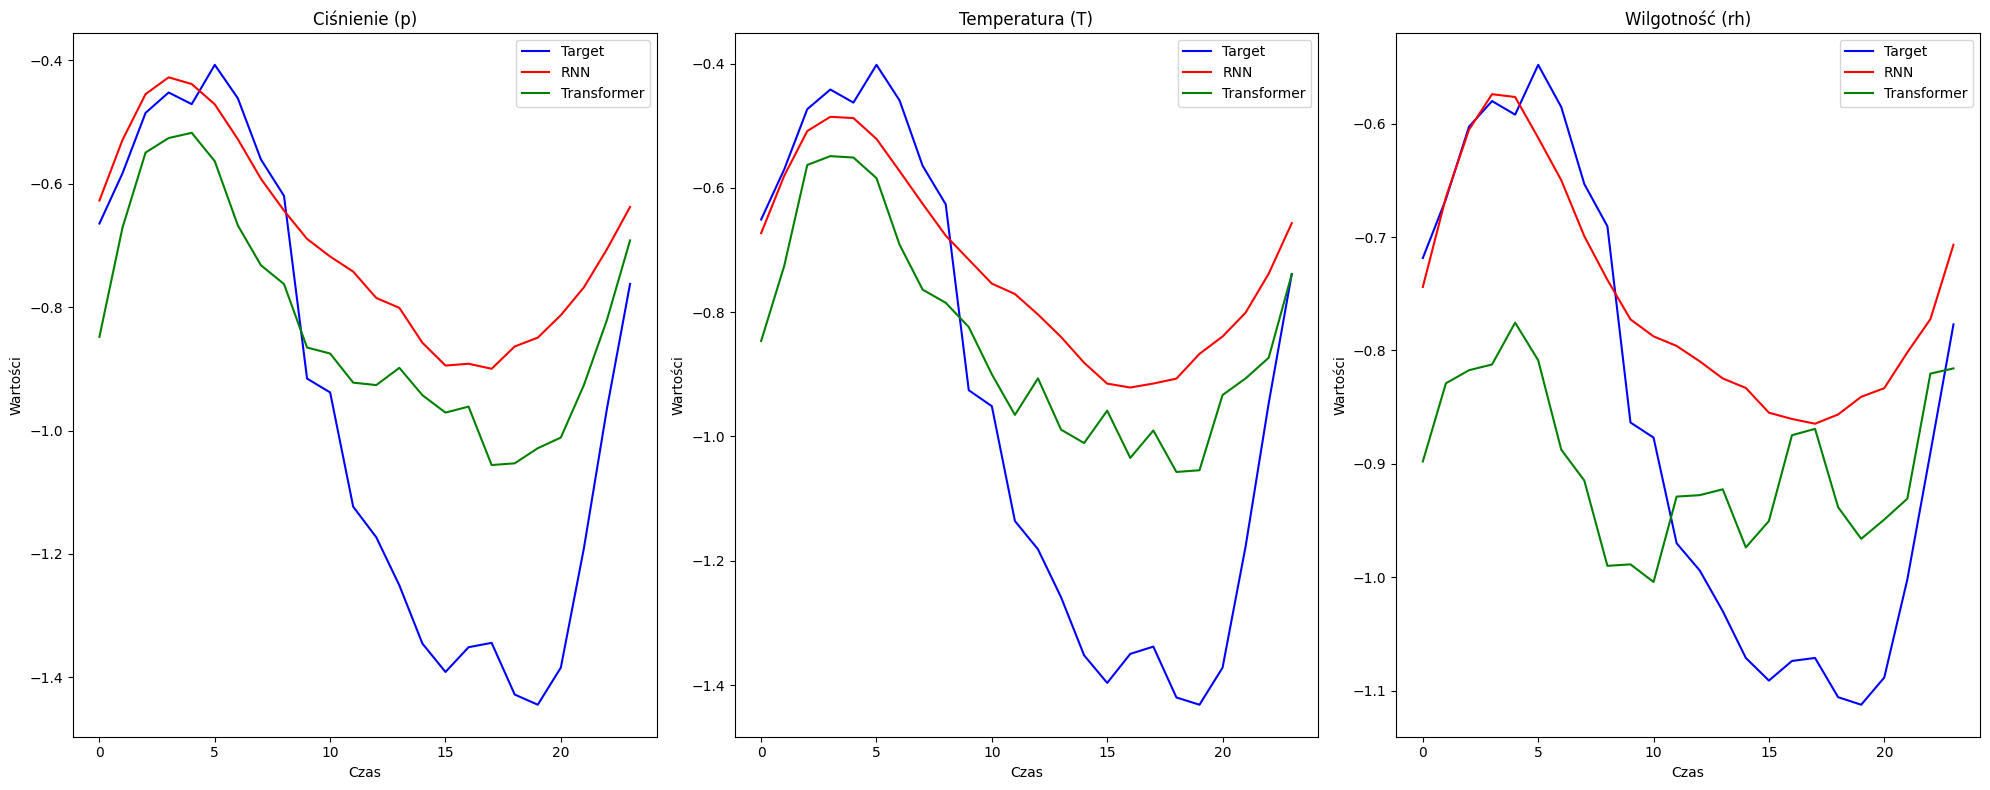

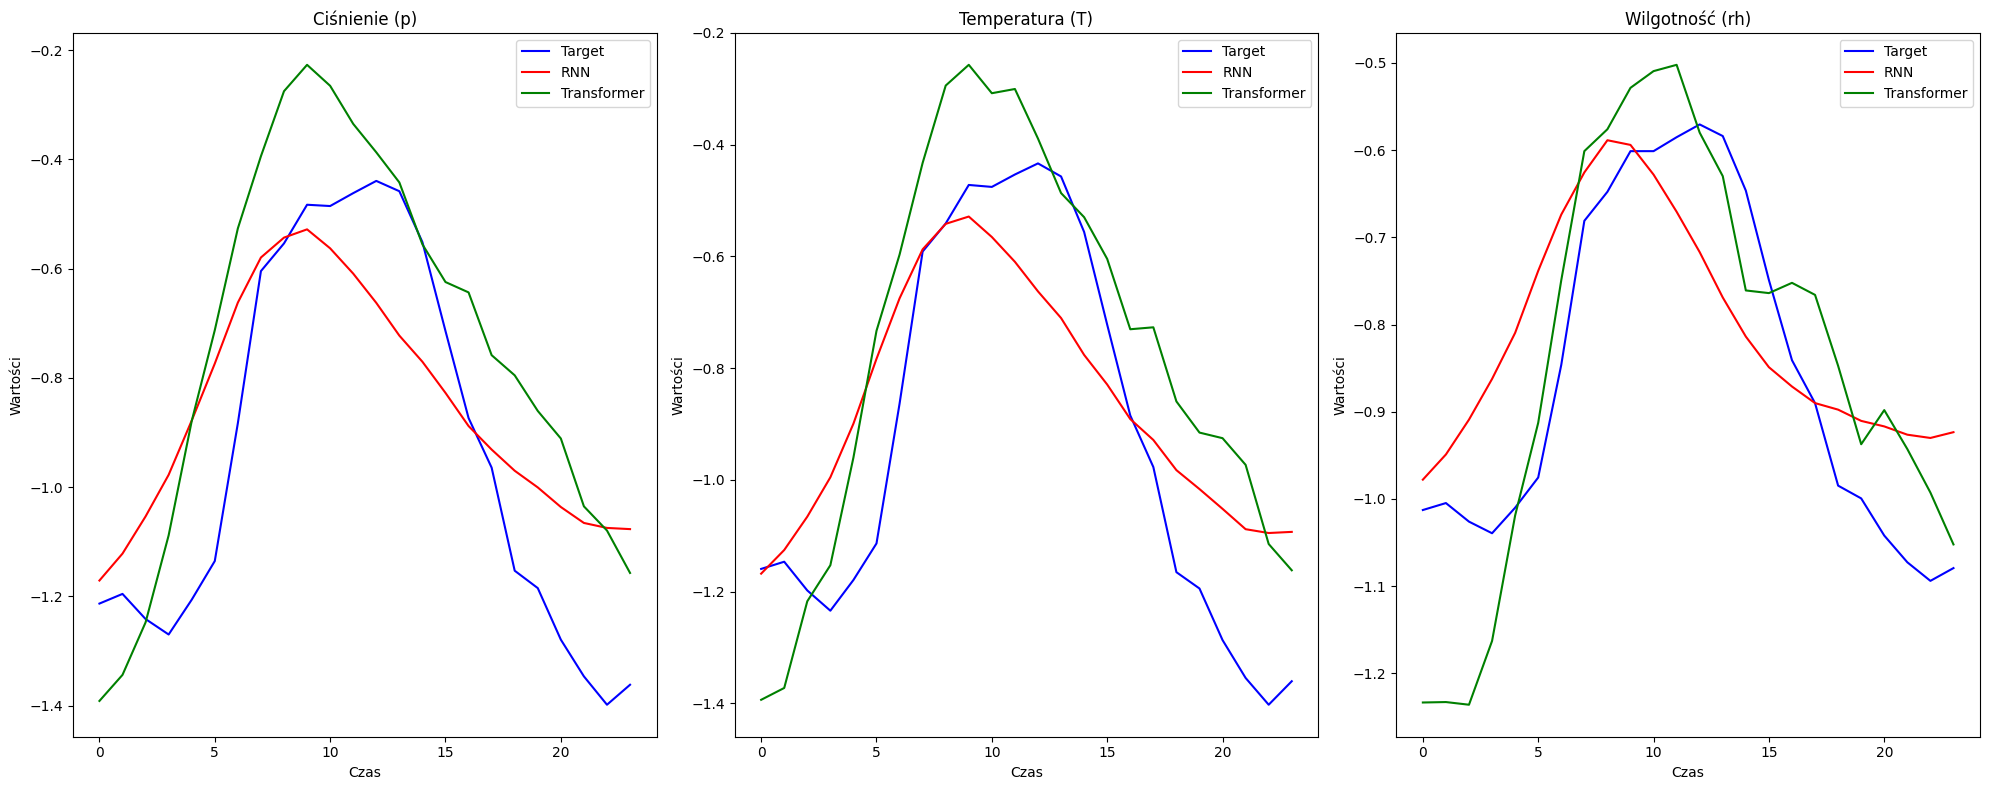

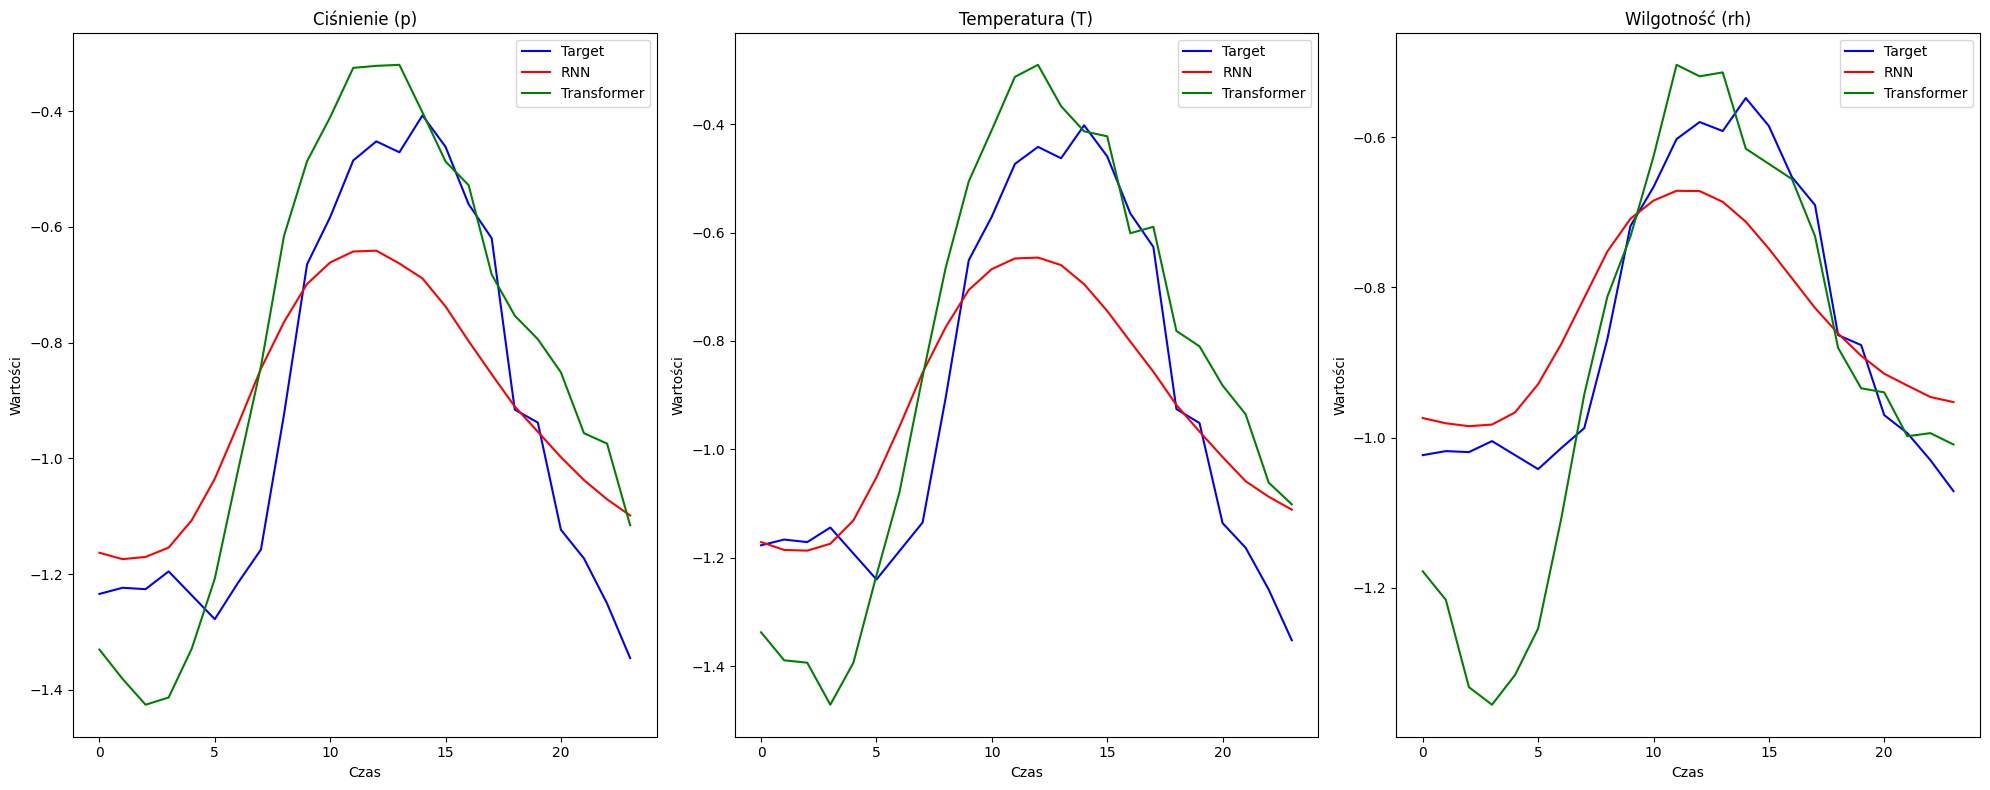

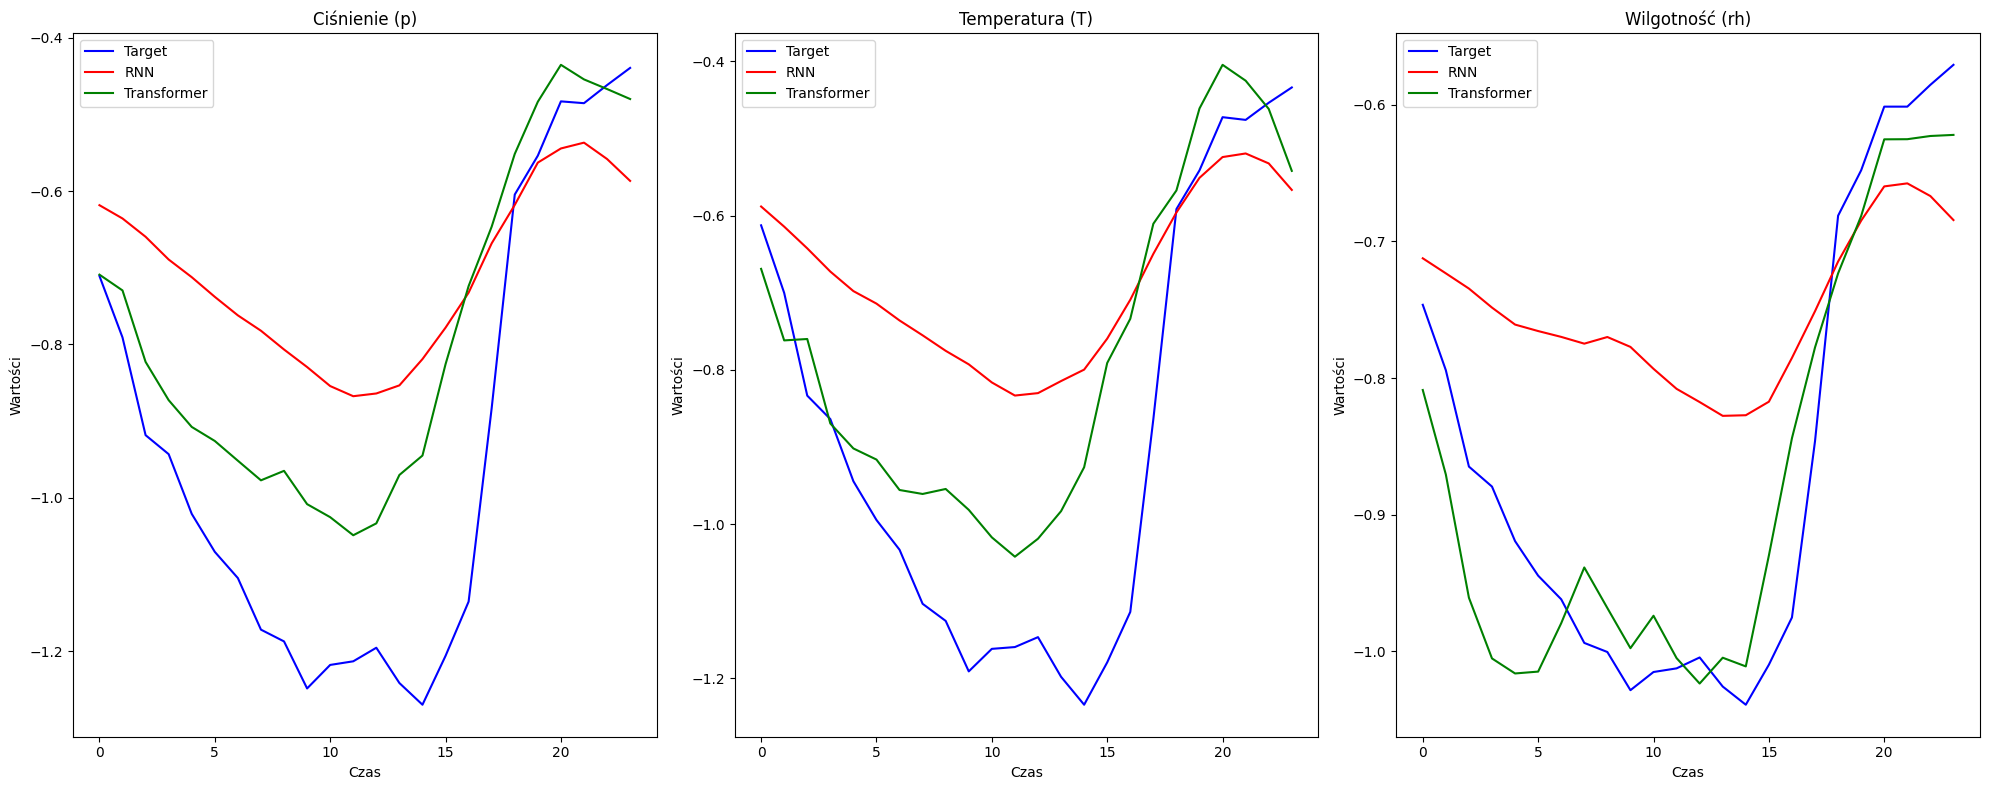

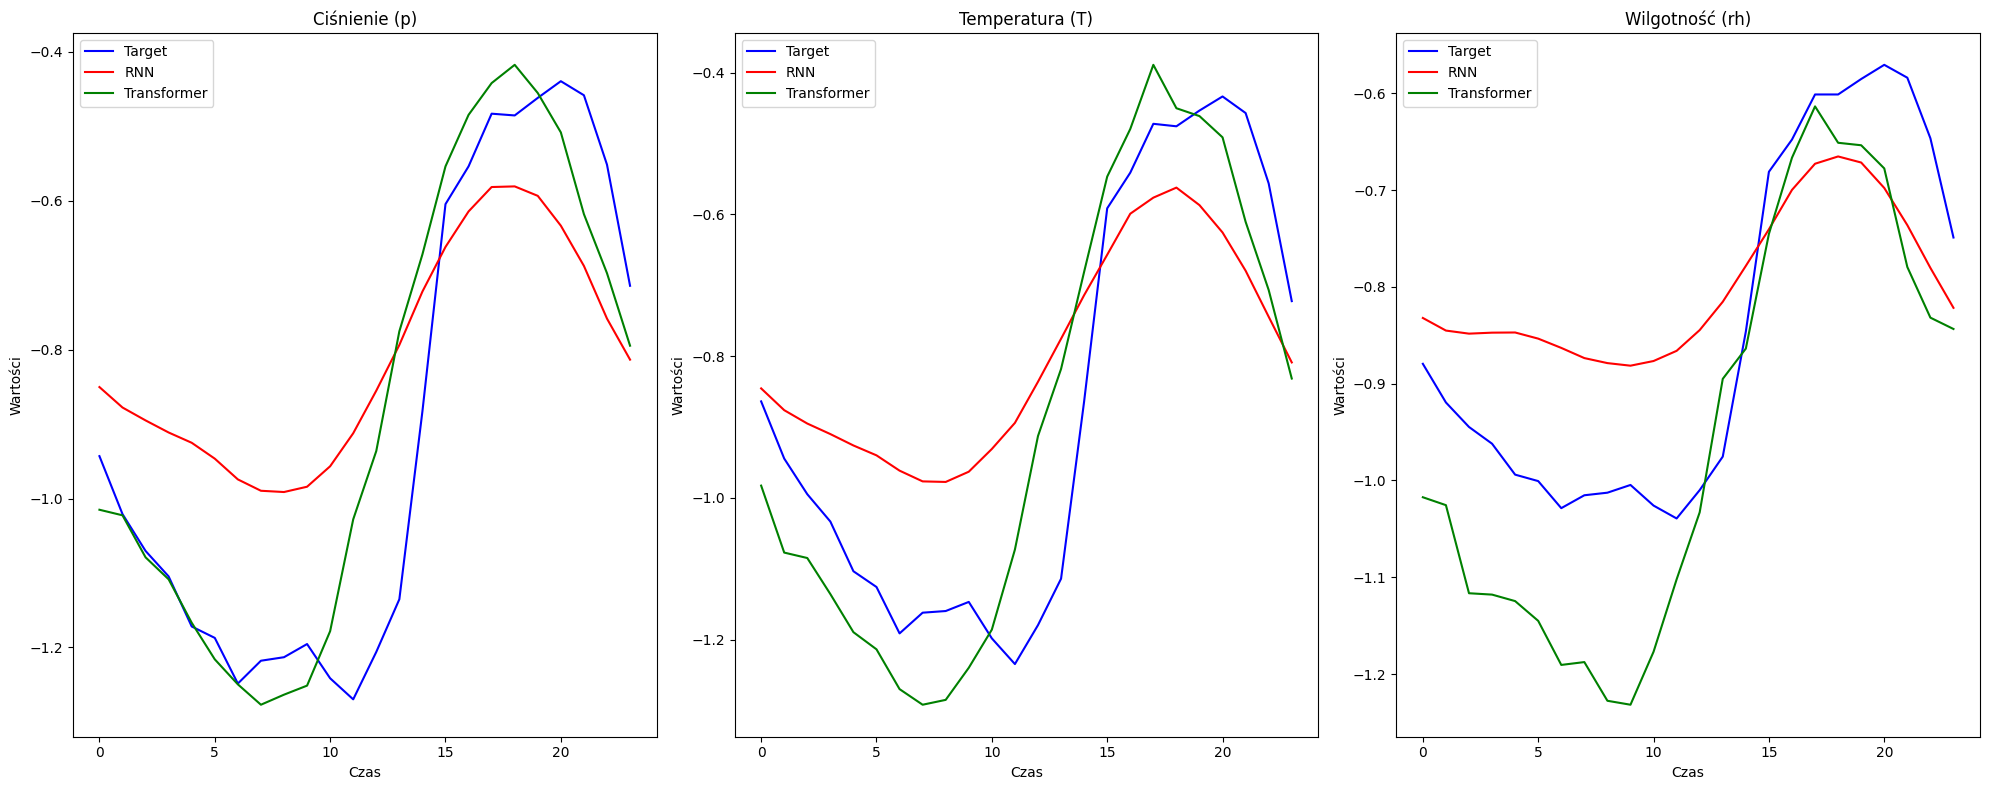

In [45]:
samples, targets = next(test_gen)

# Uzyskanie przewidywań z obu modeli
pred_rnn = model_rnn.predict(samples)

model = tuner1.get_best_models(num_models=3)[1]
pred_transformer = model.predict(samples)
index = [123, 82, 69, 16, 34]
for i in range(5):
        
    target_pressure = targets[index[i]][:,0]  # Target p (mbar)
    target_temp = targets[index[i]][:,1]      # Target T (degC)
    target_humidity = targets[index[i]][:,2]  # Target rh (%)

    pred_rnn_pressure = pred_rnn[index[i]][:,0]
    pred_rnn_temp = pred_rnn[index[i]][:,1]
    pred_rnn_humidity = pred_rnn[index[i]][:,2]

    pred_transformer_pressure = pred_transformer[index[i]][:,0]
    pred_transformer_temp = pred_transformer[index[i]][:,1]
    pred_transformer_humidity = pred_transformer[index[i]][:,2]

    # Tworzenie wykresu
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Wykres dla ciśnienia
    axes[0].set_title('Ciśnienie (p)')
    axes[0].plot(target_pressure, label='Target', color='blue')
    axes[0].plot(pred_rnn_pressure, label='RNN', color='red')
    axes[0].plot(pred_transformer_pressure, label='Transformer', color='green')

    # Wykres dla temperatury
    axes[1].set_title('Temperatura (T)')
    axes[1].plot(target_temp, label='Target', color='blue')
    axes[1].plot(pred_rnn_temp, label='RNN', color='red')
    axes[1].plot(pred_transformer_temp, label='Transformer', color='green')

    # Wykres dla wilgotności
    axes[2].set_title('Wilgotność (rh)')
    axes[2].plot(target_humidity, label='Target', color='blue')
    axes[2].plot(pred_rnn_humidity, label='RNN', color='red')
    axes[2].plot(pred_transformer_humidity, label='Transformer', color='green')

    # Ustawienie etykiet osi
    for i in range(3):
        axes[i].set_xlabel('Czas')
        axes[i].set_ylabel('Wartości')

    # Dodanie legendy do wykresów
    for i in range(3):
        axes[i].legend()

    # Dostosowanie układu
    plt.tight_layout()
    plt.show()

In [26]:
import keras.metrics

model = tuner1.get_best_models(num_models=3)[0]

metric_transformer = keras.metrics.R2Score()
metric_rnn = keras.metrics.R2Score()
for i in range(150):
    samples, targets = next(test_gen)
    new_shape = (targets.shape[0], targets.shape[1] * targets.shape[2])

    targets = targets.reshape(new_shape)

    pred_transformer = model.predict(samples)
    pred_transformer = pred_transformer.reshape(new_shape)
    pred_rnn = model_rnn.predict(samples)
    pred_rnn = pred_rnn.reshape(new_shape)

    metric_transformer.update_state(targets, pred_transformer)
    metric_rnn.update_state(targets, pred_rnn)




print(f"R^2 dla Modelu RNN: {metric_rnn.result():.4f}")
print(f"R^2 dla Modelu Transformera: {metric_transformer.result():.4f}")

/home/krzysztof/my-jupyter/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/my-jupyter/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1737573054.823945  214999 service.cc:148] XLA service 0x7672c0003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737573054.823965  214999 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-22 20:10:54.840248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproduc

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


I0000 00:00:1737573056.285993  214999 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━

In [31]:
model.save('saved_models/transformer_model.keras')